In [1]:
# change the seed before anything else
import numpy as np
np.random.seed(7)
import tensorflow as tf
tf.set_random_seed(7)
from timeit import default_timer as timer

import os
import time

import keras
keras.backend.clear_session()

import matplotlib.pyplot as plt
import sklearn

from keras.models import Sequential, Input, Model
from keras.layers import Activation
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, merge, Flatten
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.merge import concatenate
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
Using TensorFlow backend.


In [2]:
bands = 60
frames = 101
feature_size = bands * frames
num_channels = 3
num_labels = 10
data_dir = 'folds'

In [3]:
def load_all_folds(test_fold):
    assert (type(test_fold) == int)
    assert (test_fold > 0 and test_fold < 11)
    subsequent_fold = False

    train_set_range = list(range(1, 11))
    train_set_range.remove(test_fold)
    valid_fold = train_set_range.pop()

    for k in train_set_range:
        fold_name = 'fold' + str(k)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        # flip the spectrogram for each channel
        loaded_features = np.transpose(loaded_features, (0, 2, 1, 3))
        loaded_labels = np.load(labels_file)
        print("Adding ", fold_name, "New Features: ", loaded_features.shape)

        if subsequent_fold:
            train_x_loaded = np.concatenate((train_x_loaded, loaded_features))
            train_y_loaded = np.concatenate((train_y_loaded, loaded_labels))
        else:
            train_x_loaded = loaded_features
            train_y_loaded = loaded_labels
            subsequent_fold = True

    # use the penultimate fold for validation
    valid_fold_name = 'fold' + str(valid_fold)
    feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
    valid_x = np.load(feature_file)
    # flip the spectrogram for each channel
    valid_x = np.transpose(valid_x, (0, 2, 1, 3))
    valid_y = np.load(labels_file)

    # and use the last fold for testing
    test_fold_name = 'fold' + str(test_fold)
    feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
    test_x = np.load(feature_file)
    test_x = np.transpose(test_x, (0, 2, 1, 3))
    test_y = np.load(labels_file)
    return train_x_loaded, train_y_loaded, valid_x, valid_y, test_x, test_y

In [4]:
def evaluate(model, test_x, test_y):
    y_prob = model.predict(test_x, verbose=0)
    y_pred = np.argmax(y_prob, axis=-1)
    y_true = np.argmax(test_y, 1)

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
    print("\nAccuracy = {:.4f}".format(accuracy))
    print("\nError Rate = {:.4f}".format(1. - accuracy))

    return accuracy

In [5]:
def build_model():
    # create model
    
    visible = Input(shape=(frames, bands, num_channels))
    
    # medium frequency features
    # first filter
    conv1 = Conv2D(1, kernel_size=(24, 4), activation='relu', kernel_initializer='he_uniform')(visible)
    pool1 = MaxPooling2D(pool_size=(1, 2))(conv1)
    dropout1 = Dropout(0.5)(conv1)
    flat1 = Flatten()(pool1)
    # second filter
    conv2 =Conv2D(1, kernel_size=(28, 4), activation='relu', kernel_initializer='he_uniform')(visible)
    pool2 = MaxPooling2D(pool_size=(1, 2))(conv2)
    dropout2 = Dropout(0.5)(conv2)
    flat2 = Flatten()(pool2)
    # third filter
    conv3 =Conv2D(1, kernel_size=(32, 4), activation='relu', kernel_initializer='he_uniform')(visible)
    pool3 = MaxPooling2D(pool_size=(1, 2))(conv3)
    dropout3 = Dropout(0.5)(conv3)
    flat3 = Flatten()(pool3)
    # fourth filter
    conv4 =Conv2D(1, kernel_size=(36, 4), activation='relu', kernel_initializer='he_uniform')(visible)
    pool4 = MaxPooling2D(pool_size=(1, 2))(conv4)
    dropout4 = Dropout(0.5)(conv4)
    flat4 = Flatten()(pool4)
    # fifth filter
    conv5 =Conv2D(1, kernel_size=(40, 4), activation='relu', kernel_initializer='he_uniform')(visible)
    pool5 = MaxPooling2D(pool_size=(1, 2))(conv5)
    dropout5 = Dropout(0.5)(conv5)
    flat5 = Flatten()(pool5)
    
    # medium temporal filters
    # 6
    conv6 = Conv2D(1, kernel_size=(4, 24), activation='relu', kernel_initializer='he_uniform')(visible)
    pool6 = MaxPooling2D(pool_size=(2, 1))(conv6)
    dropout6 = Dropout(0.5)(conv6)
    flat6 = Flatten()(pool6)
    # 7
    conv7 = Conv2D(1, kernel_size=(4, 28), activation='relu', kernel_initializer='he_uniform')(visible)
    pool7 = MaxPooling2D(pool_size=(2, 1))(conv7)
    dropout7 = Dropout(0.5)(conv7)
    flat7 = Flatten()(pool7)
    # 8
    conv8 = Conv2D(1, kernel_size=(4, 32), activation='relu', kernel_initializer='he_uniform')(visible)
    pool8 = MaxPooling2D(pool_size=(2, 1))(conv8)
    dropout8 = Dropout(0.5)(conv8)
    flat8 = Flatten()(pool8)
    # 9
    conv9 = Conv2D(1, kernel_size=(4, 36), activation='relu', kernel_initializer='he_uniform')(visible)
    pool9 = MaxPooling2D(pool_size=(2, 1))(conv9)
    dropout9 = Dropout(0.5)(conv9)
    flat9 = Flatten()(pool9)
    # 10
    conv10 = Conv2D(1, kernel_size=(4, 40), activation='relu', kernel_initializer='he_uniform')(visible)
    pool10 = MaxPooling2D(pool_size=(2, 1))(conv10)
    dropout10 = Dropout(0.5)(conv10)
    flat10 = Flatten()(pool10)    
    
    # merge filters
    M_freq = concatenate([flat1, flat2, flat3, flat4, flat5])
                
    M_temp = concatenate([flat6, flat7, flat8, flat9, flat10])
    
    merge = concatenate([M_freq, M_temp])
    
    # interpretation layer
    hidden1 = Dense(5000, activation='relu')(merge)
    
    # prediction output
    output = Dense(10, activation='softmax')(hidden1)
    model = Model(inputs=visible, outputs=output)
    
    return model

In [6]:
# apply scaling factor to a dataset - train, validation or test
def do_scale(x4d, verbose = True):
    """Do scale on the input sequence data.

    Args:
      x34d: ndarray, input sequence data, shape: (n_clips, n_time, n_freq, channel)      
      verbose: boolean

    Returns:
      Scaled input sequence data.
    """
    t1 = time.time()    
    (n_clips, n_time, n_freq, n_channel) = x4d.shape
    x4d_scaled = np.zeros(x4d.shape)
    for channel in range(n_channel):
        x2d = x4d[:,:,:,channel].reshape((n_clips * n_time, n_freq))
        x2d_scaled = scaler_list[channel].transform(x2d)
        x3d_scaled = x2d_scaled.reshape((n_clips, n_time, n_freq))
        x4d_scaled[:,:,:,channel] = x3d_scaled

    if verbose == 1:
        print("Scaling time: %s" % (time.time() - t1,))

    return x4d_scaled

In [7]:
# earlystopping ends training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
callbacks = [early_stopping]

acc_list = []

for test_fold in range(1, 11):
    print('opening fold:', str(test_fold))

    keras.backend.clear_session()
    model = build_model()

    # compile the model
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9, nesterov=True), metrics=['accuracy'])
    train_x, train_y, valid_x, valid_y, test_x, test_y = load_all_folds(test_fold)

    # for each channel, compute scaling factor
    scaler_list = []
    (n_clips, n_time, n_freq, n_channel) = train_x.shape

    for channel in range(n_channel):
        t1 = time.time()
        xtrain_2d = train_x[:, :, :, channel].reshape((n_clips * n_time, n_freq))
        scaler = sklearn.preprocessing.StandardScaler().fit(xtrain_2d)
        # print("Channel %d Mean: %s" % (channel, scaler.mean_,))
        # print("Channel %d Std: %s" % (channel, scaler.scale_,))
        # print("Calculating scaler time: %s" % (time.time() - t1,))
        scaler_list += [scaler]

    train_x = do_scale(train_x)
    valid_x = do_scale(valid_x)
    test_x = do_scale(test_x)

    # use a batch size to fully utilize GPU power
    t1 = time.time()
    print("training model...hold tight")
    history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=callbacks,
                        batch_size=40,
                        epochs=150)
    print("training time: %s" % (time.time() - t1,))
    
    t2 = time.time()
    acc = evaluate(model, test_x, test_y)
    print("training time: %s" % (time.time() - t2,))

    acc_list += [acc]

opening fold: 1
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Adding  fold2 New Features:  (887, 101, 60, 3)
Adding  fold3 New Features:  (925, 101, 60, 3)
Adding  fold4 New Features:  (990, 101, 60, 3)
Adding  fold5 New Features:  (936, 101, 60, 3)
Adding  fold6 New Features:  (823, 101, 60, 3)
Adding  fold7 New Features:  (838, 101, 60, 3)
Adding  fold8 New Features:  (806, 101, 60, 3)
Adding  fold9 New Features:  (816, 101, 60, 3)
Scaling time: 1.8569819927215576
Scaling time: 0.2338569164276123
Scaling time: 0.24200034141540527
training model...hold tight
Train on 7021 samples, validate on 837 samples
Epoch 1/150
7021/7021 [==============================] - 14s - loss: 1.4749 - acc: 0.4726 - val_loss: 1.4010 - val_acc: 0.4743
Epoch 2/150
7021/7021 [==============================] - 8s - loss: 0.9619 - acc: 0.670

In [9]:
acc_array = np.array(acc_list)
print("acc mean %.4f acc std %.4f" % (acc_array.mean(), acc_array.std()))

acc mean 0.6169 acc std 0.0533


History keys: dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


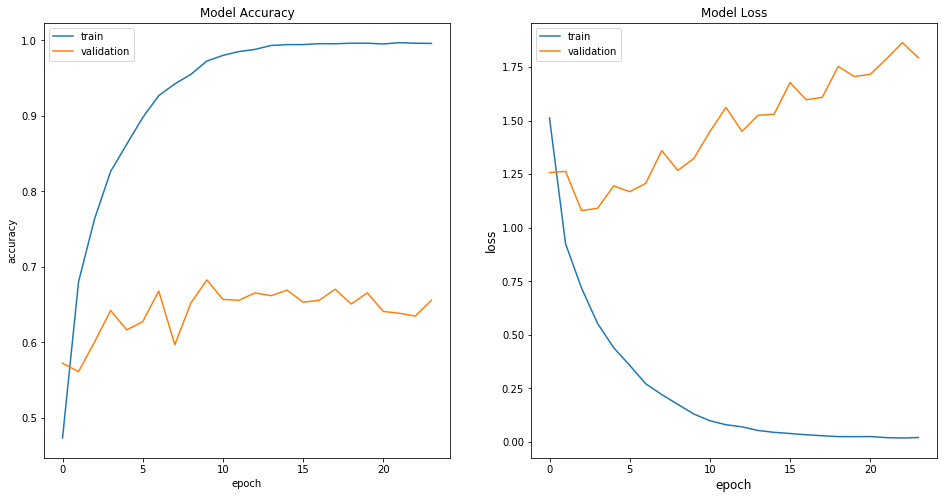

In [10]:
fig = plt.figure(figsize=(16,8))

print("History keys:", (history.history.keys()))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss', fontsize = 'large')
plt.xlabel('epoch', fontsize = 'large' )
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


800/837 [===========================>..] - ETA: 0s
Accuracy = 0.6595

Error Rate = 0.3405
Showing Confusion Matrix
                    air conditioner            horn        children             dog           drill          engine             gun          hammer           siren           music 
    air conditioner              49               0               1               0               0              35               0              14               1               0 
               horn               0              22               1               1               1               0               2               4               0               2 
           children               0               0              66              10               0               3               0               0               8              13 
                dog               1               2               8              69               3               1               2               5              

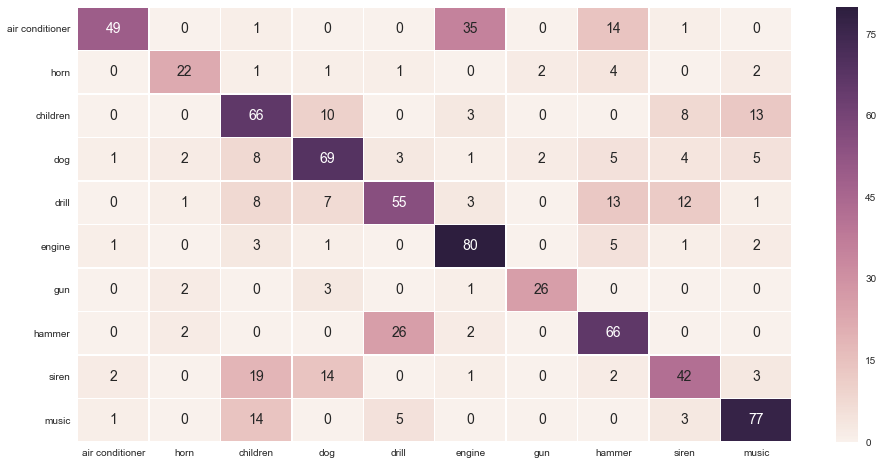

In [11]:
% matplotlib inline
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

# run a separate instance of model evaluation on test set
# to create a single confusion matrix
acc = evaluate(model, test_x, test_y)  #evaluate(model)

labels = ["air conditioner", "horn", "children", "dog", "drill", "engine", "gun", "hammer", "siren", "music"]
print("Showing Confusion Matrix")
y_prob = model.predict(test_x, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=' ')
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=' ')
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=' ')
        print()

print_cm(cm, labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(16, 8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)